In [1]:
import pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql import SQLContext
from pyspark.sql import types
from pyspark.sql.functions import col,isnan, when, count, regexp_replace, rand
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler
from sklearn.metrics import roc_curve, auc
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark import SparkContext
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import plotly.express as ex
import missingno as msno

from prettytable import PrettyTable

In [3]:
#Create a SparkSession
spark = SparkSession.builder.master('ML').getOrCreate()
#Loading the dataset
telco_churn = spark.read.csv("WA_Fn-UseC_-Telco-Customer-Churn.csv", inferSchema=True, header = True)
telco_churn.show(5)

#Count the number of rows and columns
num_rows = telco_churn.count()
num_cols = len(telco_churn.columns)

print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

23/08/19 11:19:30 WARN Utils: Your hostname, Vinays-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 172.23.147.62 instead (on interface en0)
23/08/19 11:19:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/19 11:19:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [4]:
#Check the shape of the dataframe
print((telco_churn.count(), len(telco_churn.columns)))

(7043, 21)


In [5]:
#Check the unique count
telco_churn.distinct().count()

7043

In [6]:
#Check if any rows is displaying more than once
telco_churn.groupBy(telco_churn.columns).count().filter('count>1').show(vertical=True)

(0 rows)



In [7]:
telco_churn.describe().show()

23/08/19 11:19:38 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+----------+------+------------------+-------+----------+------------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+-----+
|summary|customerID|gender|     SeniorCitizen|Partner|Dependents|            tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|    MonthlyCharges|      TotalCharges|Churn|
+-------+----------+------+------------------+-------+----------+------------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+-----+
|  count|      7043|  7043|              7043|   7043|      7043|     

In [8]:
telco_churn.toPandas().head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU,9305-CDSKC,1452-KIOVK,6713-OKOMC,7892-POOKP,6388-TABGU
gender,Female,Male,Male,Male,Female,Female,Male,Female,Female,Male
SeniorCitizen,0,0,0,0,0,0,0,0,0,0
Partner,Yes,No,No,No,No,No,No,No,Yes,No
Dependents,No,No,No,No,No,No,Yes,No,No,Yes
tenure,1,34,2,45,2,8,22,10,28,62
PhoneService,No,Yes,Yes,No,Yes,Yes,Yes,No,Yes,Yes
MultipleLines,No phone service,No,No,No phone service,No,Yes,Yes,No phone service,Yes,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic,Fiber optic,Fiber optic,DSL,Fiber optic,DSL
OnlineSecurity,No,Yes,Yes,Yes,No,No,No,Yes,No,Yes


In [9]:
#Check the schema of the dataset
telco_churn.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [10]:
#Convert the datatype of TotalCharges column
telco_churn = telco_churn.withColumn('TotalCharges', telco_churn['TotalCharges'].cast('float'))

In [11]:
#Check the updated datatypes of the columns
telco_churn.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: float (nullable = true)
 |-- Churn: string (nullable = true)



In [12]:
#Check for null values in the dataset
telco_churn.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in telco_churn.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

In [13]:
#Drop all null values in the dataset.
telco_churn = telco_churn.na.drop()
telco_churn.count()

7032

In [14]:
#Check for missing values
import missingno as msno

<AxesSubplot:>

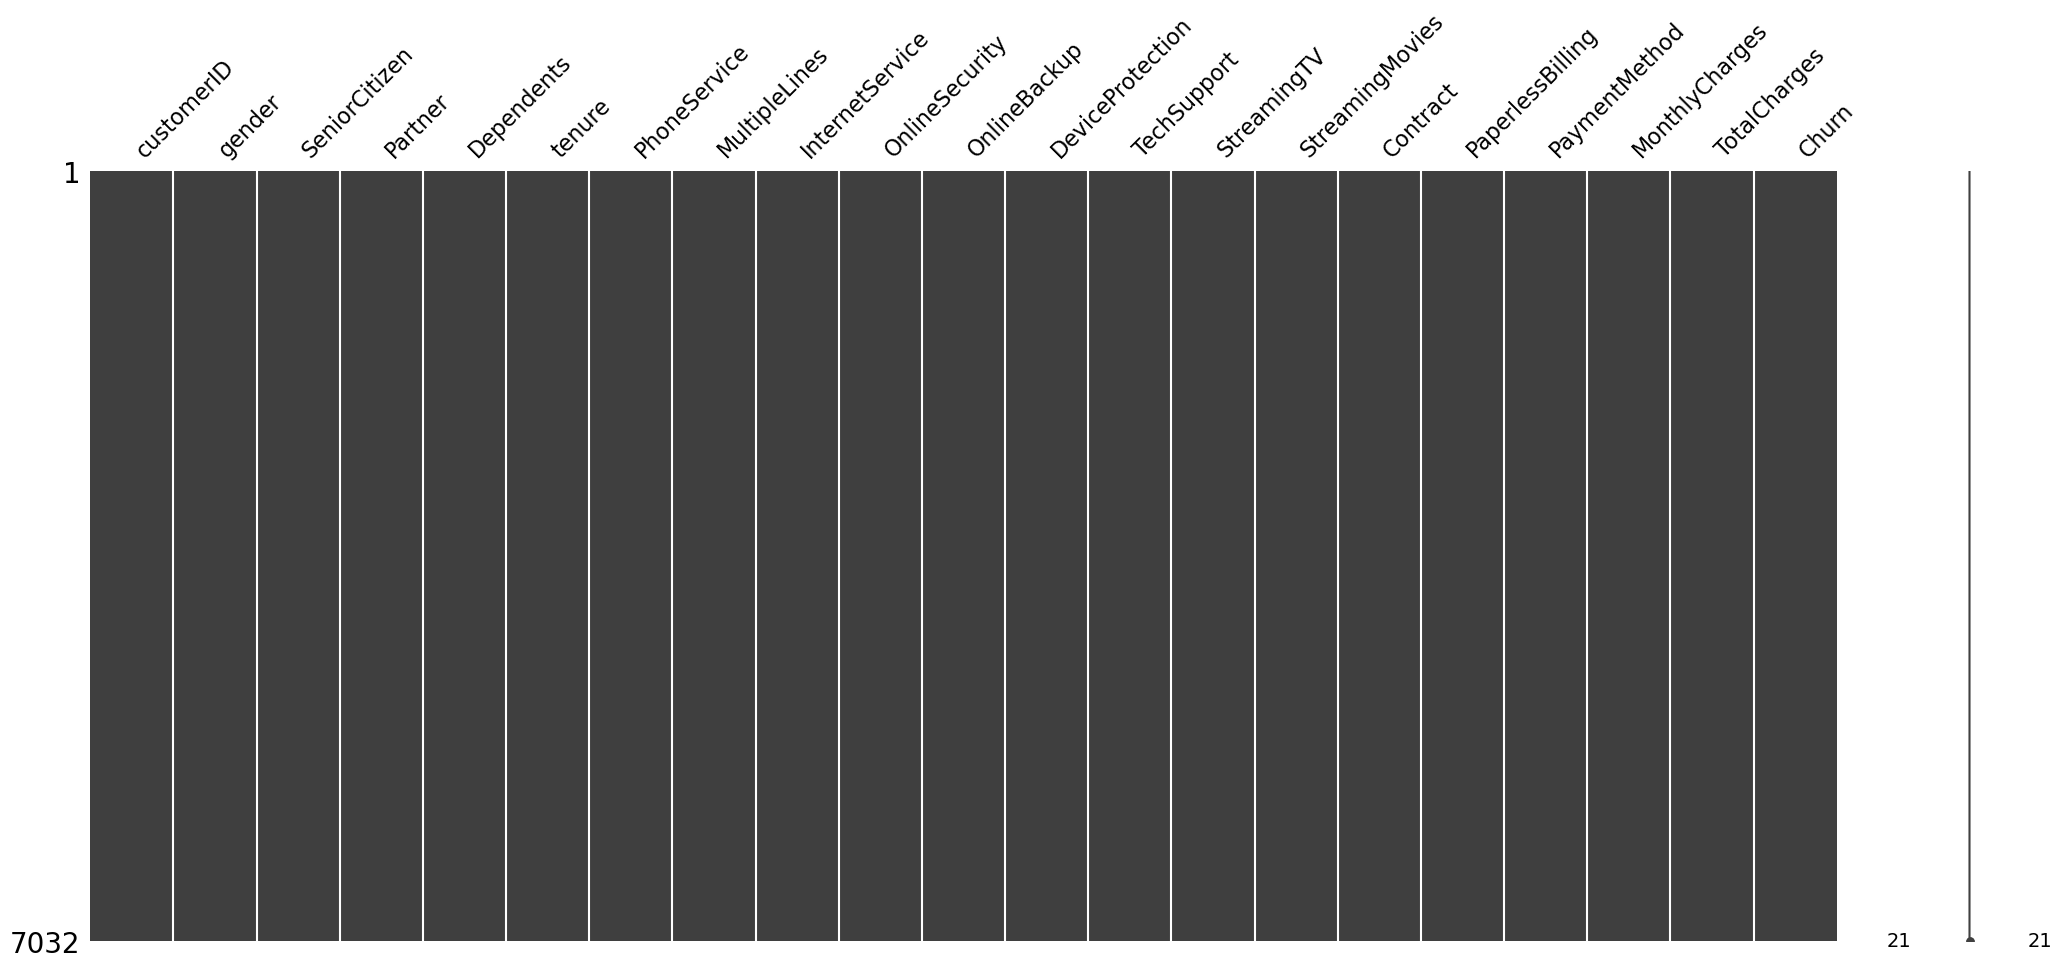

In [15]:
msno.matrix(telco_churn.toPandas())

In [58]:
#Replace 'No phone service' and 'No internet service' values with 'No' to simplify analysis
new_telco_churn = telco_churn.withColumn('MultipleLines',
regexp_replace('MultipleLines', 'No phone service', 'No'))
new_telco_churn = new_telco_churn.withColumn('OnlineBackup',
regexp_replace('OnlineBackup', 'No internet service', 'No'))
new_telco_churn = new_telco_churn.withColumn('DeviceProtection',
regexp_replace('DeviceProtection', 'No internet service', 'No'))
new_telco_churn = new_telco_churn.withColumn('TechSupport',
regexp_replace('TechSupport', 'No internet service', 'No'))
new_telco_churn = new_telco_churn.withColumn('StreamingTV',
regexp_replace('StreamingTV', 'No internet service', 'No'))
new_telco_churn = new_telco_churn.withColumn('StreamingMovies',
regexp_replace('StreamingMovies', 'No internet service', 'No'))

In [17]:
#Drop the CustomerID column from the dataset
telco_churn = telco_churn.drop('customerID')

In [22]:
#Convert all categorical columns into numerical form using StringIndexer
telco_indexer = StringIndexer(inputCols=['gender', 'Partner', 'Dependents',
                                   'PhoneService', 'MultipleLines', 'InternetService',
                                  'OnlineSecurity', 'OnlineBackup',
                                   'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                                   'Contract','PaperlessBilling',
                                   'PaymentMethod', 'Churn'], 
                        outputCols=['gender_indexed','Partner_indexed',
                                       'Dependents_indexed','PhoneService_indexed',
                                       'MultipleLines_indexed', 'InternetService_indexed','OnlineSecurity_indexed',
                                       'OnlineBackup_indexed', 'DeviceProtection_indexed','TechSupport_indexed',
                                       'StreamingTV_indexed', 'StreamingMovies_indexed', 'Contract_indexed',
                                       'PaperlessBilling_indexed', 'PaymentMethod_indexed', 'Churn_indexed'])

new_telco_churn_encoded = telco_indexer.fit(new_telco_churn_encoded).transform(new_telco_churn_encoded)

In [23]:
#Assemble the columns into one single vector column
required_features = ['SeniorCitizen', 'tenure',
                     'MonthlyCharges', 'TotalCharges', 'PhoneService_indexed','StreamingTV_indexed',
                     'Dependents_indexed', 'InternetService_indexed','MultipleLines_indexed',
                     'TechSupport_indexed', 'Contract_indexed','DeviceProtection_indexed',
                     'StreamingMovies_indexed','OnlineBackup_indexed', 'PaymentMethod_indexed', 
                     'gender_indexed','PaperlessBilling_indexed','OnlineSecurity_indexed', 'Partner_indexed']

telco_assembler = VectorAssembler(inputCols=required_features,
                           outputCol='NewIndependentFeatures')


In [24]:
telco_churn_output = telco_assembler.transform(new_telco_churn_encoded)
telco_churn_output.printSchema()


root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: float (nullable = true)
 |-- Churn: string (nullable = true)
 |-- gender_indexed: double (nullable = false)
 |-- Partner_indexed: double (nullable = false)
 |-- Dependents_indexed: doubl

In [27]:
#Save both the column into a new dataframe
telco_churn_output.select('NewIndependentFeatures').show()
telco_churn_new_df = telco_churn_output.select('NewIndependentFeatures',
'Churn_indexed')
telco_churn_new_df.show()

+----------------------+
|NewIndependentFeatures|
+----------------------+
|  (19,[1,2,3,4,7,13...|
|  (19,[1,2,3,7,10,1...|
|  (19,[1,2,3,7,13,1...|
|  (19,[1,2,3,4,7,9,...|
|  (19,[1,2,3,15],[2...|
|  (19,[1,2,3,5,8,11...|
|  (19,[1,2,3,5,6,8,...|
|  (19,[1,2,3,4,7,14...|
|  (19,[1,2,3,5,8,9,...|
|  (19,[1,2,3,6,7,10...|
|  (19,[1,2,3,6,7,14...|
|  (19,[1,2,3,7,10,1...|
|  (19,[1,2,3,5,8,10...|
|  (19,[1,2,3,5,8,11...|
|  (19,[1,2,3,5,9,11...|
|  [0.0,69.0,113.25,...|
|  (19,[1,2,3,7,10,1...|
|  [0.0,71.0,106.7,7...|
|  (19,[1,2,3,6,7,9,...|
|  (19,[1,2,3,11,12,...|
+----------------------+
only showing top 20 rows

+----------------------+-------------+
|NewIndependentFeatures|Churn_indexed|
+----------------------+-------------+
|  (19,[1,2,3,4,7,13...|          0.0|
|  (19,[1,2,3,7,10,1...|          0.0|
|  (19,[1,2,3,7,13,1...|          1.0|
|  (19,[1,2,3,4,7,9,...|          0.0|
|  (19,[1,2,3,15],[2...|          1.0|
|  (19,[1,2,3,5,8,11...|          1.0|
|  (19,[1,2,3,5,6,8,...

In [28]:
#Count the number of rows in each group of InternetService
telco_churn.groupBy("InternetService").count().show()

+---------------+-----+
|InternetService|count|
+---------------+-----+
|    Fiber optic| 3096|
|             No| 1520|
|            DSL| 2416|
+---------------+-----+



In [29]:
#Count the number of rows in each group of Gender
telco_churn.groupBy("gender").count().show()

+------+-----+
|gender|count|
+------+-----+
|Female| 3483|
|  Male| 3549|
+------+-----+



In [30]:
#Count the number of rows in each group of PaymentMethod
telco_churn.groupBy("PaymentMethod").count().show()

+--------------------+-----+
|       PaymentMethod|count|
+--------------------+-----+
|Credit card (auto...| 1521|
|        Mailed check| 1604|
|Bank transfer (au...| 1542|
|    Electronic check| 2365|
+--------------------+-----+



In [31]:
#Count the number of rows in each group of Contract
telco_churn.groupBy("Contract").count().show()

+--------------+-----+
|      Contract|count|
+--------------+-----+
|Month-to-month| 3875|
|      One year| 1472|
|      Two year| 1685|
+--------------+-----+



<AxesSubplot:xlabel='Churn', ylabel='count'>

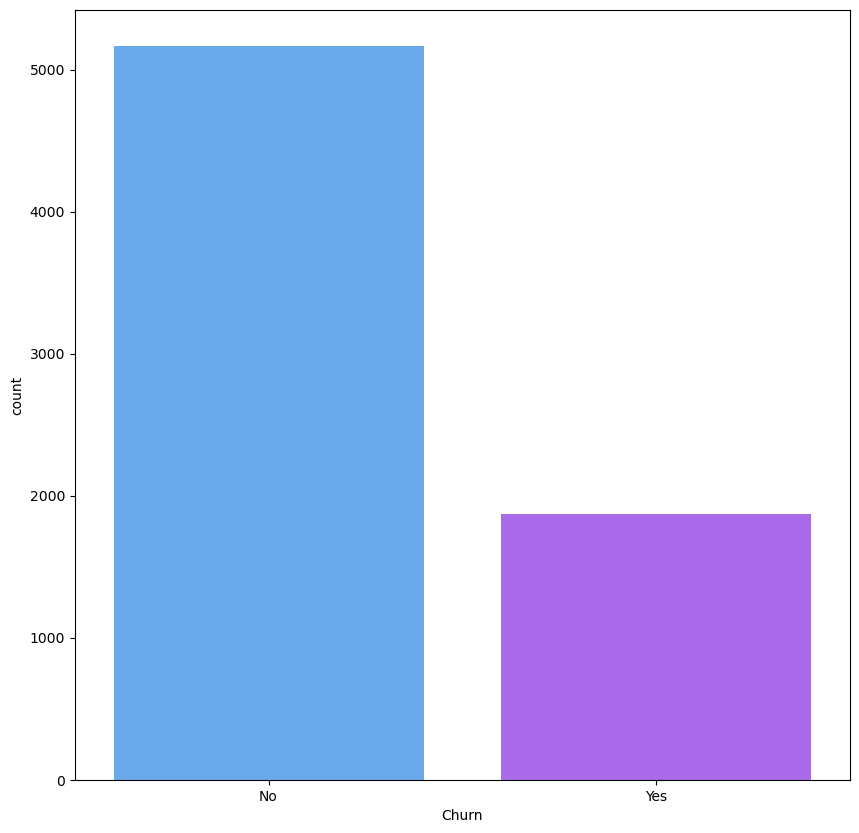

In [32]:
#Visualising the distribution of the Churn Column
plt.figure(figsize=(10,10))
sns.countplot(x='Churn', data=telco_churn.toPandas(), palette='cool')

In [33]:
# StandardScaler
telco_scaler = StandardScaler(inputCol='NewIndependentFeatures', outputCol="scaledFeatures")

# Compute summary statistics by fitting the StandardScaler
telco_scaler_model = telco_scaler.fit(telco_churn_output)

# Normalize each feature to have unit standard deviation.
telco_scaled_data = telco_scaler_model.transform(telco_churn_output)
telco_scaled_data.show()

+------+-------------+-------+----------+------+------------+-------------+---------------+-------------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+--------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+----------------------+--------------------+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|     OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|gender_indexed|Partner_indexed|Dependents_indexed|PhoneService_indexed|MultipleLines_indexe

In [34]:
#Split the dataset into train and test data sets
(train_scaled, test_scaled) = telco_scaled_data.randomSplit([0.7, 0.3])

In [35]:
print("Training Data: " + str(train_scaled.count()))
print("Test Data: " + str(test_scaled.count()))


Training Data: 4894
Test Data: 2138


In [36]:
#Initialize the Classifiers
lr_actual = LogisticRegression(labelCol='Churn_indexed', featuresCol='NewIndependentFeatures')
rf_actual = RandomForestClassifier(labelCol="Churn_indexed",featuresCol="NewIndependentFeatures", numTrees=20)
dtc_actual = DecisionTreeClassifier(labelCol="Churn_indexed",featuresCol="NewIndependentFeatures")
gbt_actual = GBTClassifier(labelCol="Churn_indexed",featuresCol="NewIndependentFeatures", maxIter=10)

#Train the models on the actual data
lr_model = lr_actual.fit(train_scaled)
rf_model = rf_actual.fit(train_scaled)
dtc_model = dtc_actual.fit(train_scaled)
gbt_model = gbt_actual.fit(train_scaled)

# Use the trained model to predict the labels of the actual data
lr_predict = lr_model.transform(test_scaled)
rf_predict = rf_model.transform(test_scaled)
dtc_predict = dtc_model.transform(test_scaled)
gbt_predict = gbt_model.transform(test_scaled)

#Evaluate the accuracy of the model
accuray_eval = MulticlassClassificationEvaluator(labelCol='Churn_indexed', 
                                                  predictionCol='prediction', metricName='accuracy')
lr_accuracy = accuray_eval.evaluate(lr_predict)
rf_accuracy = accuray_eval.evaluate(rf_predict)
dtc_accuracy = accuray_eval.evaluate(dtc_predict)
gbt_accuracy = accuray_eval.evaluate(gbt_predict)

#Evaluate the recall score of the model
recall_eval = MulticlassClassificationEvaluator(labelCol='Churn_indexed', 
                                                 predictionCol='prediction', metricName="weightedRecall")
lr_recall = recall_eval.evaluate(lr_predict)
rf_recall = recall_eval.evaluate(rf_predict)
dtc_recall = recall_eval.evaluate(dtc_predict)
gbt_recall = recall_eval.evaluate(gbt_predict)

#Evaluate the f1 score of the model
f1_eval = MulticlassClassificationEvaluator(labelCol='Churn_indexed', 
                                                 predictionCol='prediction', metricName="f1")
lr_f1 = f1_eval.evaluate(lr_predict)
rf_f1 = f1_eval.evaluate(rf_predict)
dtc_f1 = f1_eval.evaluate(dtc_predict)
gbt_f1 = f1_eval.evaluate(gbt_predict)

#Evaluate the precision score of the model
precision_eval = MulticlassClassificationEvaluator(labelCol='Churn_indexed', 
                                                        predictionCol='prediction', metricName="weightedPrecision")
lr_precision = precision_eval.evaluate(lr_predict)
rf_precision = precision_eval.evaluate(rf_predict)
dtc_precision = precision_eval.evaluate(dtc_predict)
gbt_precision = precision_eval.evaluate(gbt_predict)

#Evaluate the ROC curve value of the model
roc_eval = BinaryClassificationEvaluator(labelCol='Churn_indexed', rawPredictionCol="rawPrediction")
lr_roc = roc_eval.evaluate(lr_predict, {roc_eval.metricName: 'areaUnderROC'})
rf_roc = roc_eval.evaluate(rf_predict, {roc_eval.metricName: 'areaUnderROC'})
dtc_roc = roc_eval.evaluate(dtc_predict, {roc_eval.metricName: 'areaUnderROC'})
gbt_roc = roc_eval.evaluate(gbt_predict, {roc_eval.metricName: 'areaUnderROC'})

#Evaluate the confusion matrix of the model
lr_predict_label = lr_predict.select(['Churn_indexed', 'prediction'])
rf_predict_label = rf_predict.select(['Churn_indexed', 'prediction'])
dtc_predict_label = dtc_predict.select(['Churn_indexed', 'prediction'])
gbt_predict_label = gbt_predict.select(['Churn_indexed', 'prediction'])

#Print the results of the models
print("Logistic Regression Accuracy:", lr_accuracy)
print("Logistic Regression Recall:", lr_recall)
print("Logistic Regression Precision:", lr_precision)
print("Logistic Regression F1 Score:", lr_f1)
print("Logistic Regression ROC Curve:", lr_roc)
lr_predict_label.groupby(['Churn_indexed', 'prediction']).count().show()

print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Recall:", rf_recall)
print("Random Forest Precision:", rf_precision)
print("Random Forest F1 Score:", rf_f1)
print("Random Forest ROC Curve:", rf_roc)
rf_predict_label.groupby(['Churn_indexed', 'prediction']).count().show()

print("Decision Tree Accuracy:", dtc_accuracy)
print("Decision Tree Recall:", dtc_recall)
print("Decision Tree Precision:", dtc_precision)
print("Decision Tree F1 Score:", dtc_f1)
print("Decision Tree ROC Curve:", dtc_roc)
dtc_predict_label.groupby(['Churn_indexed', 'prediction']).count().show()

print("Gradient-boosted Tree Accuracy:", gbt_accuracy)
print("Gradient-boosted Tree Recall:", gbt_recall)
print("Gradient-boosted Tree Precision:", gbt_precision)
print("Gradient-boosted Tree F1 Score:", gbt_f1)
print("Gradient-boosted Tree ROC Curve:", gbt_roc)
gbt_predict_label.groupby(['Churn_indexed', 'prediction']).count().show()

23/08/19 11:20:42 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Logistic Regression Accuracy: 0.7960710944808232
Logistic Regression Recall: 0.7960710944808231
Logistic Regression Precision: 0.7868134177251078
Logistic Regression F1 Score: 0.7893058767291159
Logistic Regression ROC Curve: 0.8337865837865819
+-------------+----------+-----+
|Churn_indexed|prediction|count|
+-------------+----------+-----+
|          1.0|       1.0|  303|
|          0.0|       1.0|  167|
|          1.0|       0.0|  269|
|          0.0|       0.0| 1399|
+-------------+----------+-----+

Random Forest Accuracy: 0.7853133769878391
Random Forest Recall: 0.7853133769878391
Random Forest Precision: 0.7699610539451642
Random Forest F1 Score: 0.7650543897800053
Random Forest ROC Curve: 0.8370229706436616
+-------------+----------+-----+
|Churn_indexed|prediction|count|
+-------------+----------+-----+
|          1.0|       1.0|  225|
|          0.0|       1.0|  112|
|          1.0|       0.0|  347|
|          0.0|       0.0| 1454|
+-------------+----------+-----+

Decision T

In [37]:
telco_scaled_data.select("Churn_indexed").groupBy("Churn_indexed").count().collect()

[Row(Churn_indexed=0.0, count=5163), Row(Churn_indexed=1.0, count=1869)]

In [39]:
#Oversample technique to balance the dataset
telco_majority = telco_scaled_data.where(telco_scaled_data.Churn_indexed == '0.0')
telco_minority = telco_scaled_data.where(telco_scaled_data.Churn_indexed == '1.0')
fraction = (telco_scaled_data.where(telco_scaled_data.Churn_indexed == '0.0').count()) / (telco_scaled_data.where(telco_scaled_data.Churn_indexed == '1.0').count())
telco_minority_upsample = telco_minority.sample(True,fraction,42)

In [40]:
telco_balanced = telco_minority_upsample.unionAll(telco_majority)
telco_balanced = telco_balanced.orderBy(rand())
telco_balanced.groupBy(telco_balanced.Churn_indexed).count().show()

+-------------+-----+
|Churn_indexed|count|
+-------------+-----+
|          1.0| 5247|
|          0.0| 5163|
+-------------+-----+



In [41]:
(train_oversample, test_oversample) = telco_balanced.randomSplit([0.7, 0.3])

In [42]:
print("Training Data: " + str(train_oversample.count()))
print("Test Data: " + str(test_oversample.count()))


Training Data: 7202
Test Data: 3208


In [46]:
#Initialize the Classifiers
lr_oversample = LogisticRegression(labelCol='Churn_indexed', featuresCol='NewIndependentFeatures')
rf_oversample = RandomForestClassifier(labelCol="Churn_indexed",featuresCol="NewIndependentFeatures", numTrees=20)
dtc_oversample = DecisionTreeClassifier(labelCol="Churn_indexed",featuresCol="NewIndependentFeatures")
gbt_oversample = GBTClassifier(labelCol="Churn_indexed",featuresCol="NewIndependentFeatures", maxIter=10)

#Train the models on the oversample data
lr_model_oversample = lr_oversample.fit(train_oversample)
rf_model_oversample = rf_oversample.fit(train_oversample)
dtc_model_oversample = dtc_oversample.fit(train_oversample)
gbt_model_oversample = gbt_oversample.fit(train_oversample)

# Use the trained model to predict the labels of the oversample data
lr_pred_oversample = lr_model_oversample.transform(test_oversample)
rf_pred_oversample = rf_model_oversample .transform(test_oversample)
dtc_pred_oversample = dtc_model_oversample.transform(test_oversample)
gbt_pred_oversample = gbt_model_oversample.transform(test_oversample)

#Evaluate the accuracy of the model
accuracy_oversample = MulticlassClassificationEvaluator(labelCol='Churn_indexed', 
                                                             predictionCol='prediction', metricName='accuracy')
lr_accuracy_oversample = accuracy_oversample.evaluate(lr_pred_oversample)
rf_accuracy_oversample = accuracy_oversample.evaluate(rf_pred_oversample)
dtc_accuracy_oversample = accuracy_oversample.evaluate(dtc_pred_oversample)
gbt_accuracy_oversample = accuracy_oversample.evaluate(gbt_pred_oversample)

#Evaluate the recall score of the model
recall_oversample = MulticlassClassificationEvaluator(labelCol='Churn_indexed', 
                                                 predictionCol='prediction', metricName="weightedRecall")
lr_recall_oversample = recall_oversample.evaluate(lr_pred_oversample)
rf_recall_oversample = recall_oversample.evaluate(rf_pred_oversample)
dtc_recall_oversample = recall_oversample.evaluate(dtc_pred_oversample)
gbt_recall_oversample = recall_oversample.evaluate(gbt_pred_oversample)

#Evaluate the f1 score of the model
f1_oversample = MulticlassClassificationEvaluator(labelCol='Churn_indexed', 
                                                            predictionCol='prediction', metricName="f1")
lr_f1_oversample = f1_oversample.evaluate(lr_pred_oversample)
rf_f1_oversample = f1_oversample.evaluate(rf_pred_oversample)
dtc_f1_oversample = f1_oversample.evaluate(dtc_pred_oversample)
gbt_f1_oversample = f1_oversample.evaluate(gbt_pred_oversample)

#Evaluate the precision score of the model
precision_oversample = MulticlassClassificationEvaluator(labelCol='Churn_indexed', 
                                                                   predictionCol='prediction', 
                                                                   metricName="weightedPrecision")
lr_precision_oversample = precision_oversample.evaluate(lr_pred_oversample)
rf_precision_oversample = precision_oversample.evaluate(rf_pred_oversample)
dtc_precision_oversample = precision_oversample.evaluate(dtc_pred_oversample)
gbt_precision_oversample = precision_oversample.evaluate(gbt_pred_oversample)

#Evaluate the ROC curve value of the model
roc_oversample = BinaryClassificationEvaluator(labelCol='Churn_indexed', 
                                                           rawPredictionCol="rawPrediction")
lr_roc_oversample = roc_oversample.evaluate(lr_pred_oversample, 
                                                        {roc_oversample.metricName: 'areaUnderROC'})
rf_roc_oversample = roc_oversample.evaluate(rf_pred_oversample, 
                                                        {roc_oversample.metricName: 'areaUnderROC'})
dtc_roc_oversample = roc_oversample.evaluate(dtc_pred_oversample, 
                                                         {roc_oversample.metricName: 'areaUnderROC'})
gbt_roc_oversample = roc_oversample.evaluate(gbt_pred_oversample, 
                                                         {roc_oversample.metricName: 'areaUnderROC'})

#Evaluate the confusion matrix of the model
lr_pred_label_oversample = lr_pred_oversample.select(['Churn_indexed', 'prediction'])
rf_pred_label_oversample = rf_pred_oversample.select(['Churn_indexed', 'prediction'])
dtc_pred_label_oversample = dtc_pred_oversample.select(['Churn_indexed', 'prediction'])
gbt_pred_label_oversample = gbt_pred_oversample.select(['Churn_indexed', 'prediction'])

#Print the results of the models
print("Logistic Regression Accuracy(Oversample):", lr_accuracy_oversample)
print("Logistic Regression Recall(Oversample):", lr_recall_oversample)
print("Logistic Regression Precision(Oversample):", lr_precision_oversample)
print("Logistic Regression F1 Score(Oversample):", lr_f1_oversample)
print("Logistic Regression ROC Curve(Oversample):", lr_roc_oversample)
lr_pred_label_oversample.groupby(['Churn_indexed', 'prediction']).count().show()

print("Random Forest Accuracy(Oversample):", rf_accuracy_oversample)
print("Random Forest Recall(Oversample):", rf_recall_oversample)
print("Random Forest Precision(Oversample):", rf_precision_oversample)
print("Random Forest F1 Score(Oversample):", rf_f1_oversample)
print("Random Forest ROC Curve(Oversample):", rf_roc_oversample)
rf_pred_label_oversample.groupby(['Churn_indexed', 'prediction']).count().show()

print("Decision Tree Accuracy(Oversample):", dtc_accuracy_oversample)
print("Decision Tree Recall(Oversample):", dtc_recall_oversample)
print("Decision Tree Precision(Oversample):", dtc_precision_oversample)
print("Decision Tree F1 Score(Oversample):", dtc_f1_oversample)
print("Decision Tree ROC Curve(Oversample):", dtc_roc_oversample)
dtc_pred_label_oversample.groupby(['Churn_indexed', 'prediction']).count().show()

print("Gradient-boosted Tree Accuracy(Oversample):", gbt_accuracy_oversample)
print("Gradient-boosted Tree Recall(Oversample):", gbt_recall_oversample)
print("Gradient-boosted Tree Precision(Oversample):", gbt_precision_oversample)
print("Gradient-boosted Tree F1 Score(Oversample):", gbt_f1_oversample)
print("Gradient-boosted Tree ROC Curve(Oversample):", gbt_roc_oversample)
gbt_pred_label_oversample.groupby(['Churn_indexed', 'prediction']).count().show()

Logistic Regression Accuracy(Oversample): 0.7627805486284289
Logistic Regression Recall(Oversample): 0.7627805486284289
Logistic Regression Precision(Oversample): 0.7630391657596545
Logistic Regression F1 Score(Oversample): 0.7625959880408426
Logistic Regression ROC Curve(Oversample): 0.847739966368259
+-------------+----------+-----+
|Churn_indexed|prediction|count|
+-------------+----------+-----+
|          1.0|       1.0| 1285|
|          0.0|       1.0|  413|
|          1.0|       0.0|  348|
|          0.0|       0.0| 1162|
+-------------+----------+-----+

Random Forest Accuracy(Oversample): 0.7749376558603491
Random Forest Recall(Oversample): 0.7749376558603491
Random Forest Precision(Oversample): 0.7756125924792424
Random Forest F1 Score(Oversample): 0.7746351987828346
Random Forest ROC Curve(Oversample): 0.8519499606333649
+-------------+----------+-----+
|Churn_indexed|prediction|count|
+-------------+----------+-----+
|          1.0|       1.0| 1318|
|          0.0|       1.

In [50]:
#Create a logistic regression estimator with a parameter grid to search over
lr = LogisticRegression(labelCol='Churn_indexed', featuresCol='NewIndependentFeatures')

lr_paramGrid = (ParamGridBuilder()).addGrid(lr.regParam, [0.01, 0.1, 1.0]).addGrid(lr.elasticNetParam, 
                                                                                   [0.0, 0.5, 1.0]).build()

#Define an evaluation metric to use for Grid Search
lr_evaluator = BinaryClassificationEvaluator(labelCol='Churn_indexed')

#Use a cross-validation object to fit the model
cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_paramGrid, evaluator=lr_evaluator, numFolds=5)
cvModel = cv.fit(train_oversample)

#Train the LR model with the best parameters
lr_bestModel = cvModel.bestModel
lr_best_auc = lr_evaluator.evaluate(lr_bestModel.transform(train_oversample))

print("Best regParam:", lr_bestModel.getRegParam())
print("Best elasticNetParam:", lr_bestModel.getElasticNetParam())


#Create a random forest estimator with a parameter grid to search over
rf = RandomForestClassifier(labelCol='Churn_indexed', featuresCol='NewIndependentFeatures')

rf_paramGrid = (ParamGridBuilder()).addGrid(rf.numTrees, [10, 30]).addGrid(rf.maxDepth, 
                                                                                   [1, 3, 5]).build()

#Define an evaluation metric to use for Grid Search
rf_evaluator = BinaryClassificationEvaluator(labelCol='Churn_indexed')

#Use a cross-validation object to fit the model
cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_paramGrid, evaluator=rf_evaluator, numFolds=5)
cvModel = cv.fit(train_oversample)

#Train the RF model with the best parameters
rf_bestModel = cvModel.bestModel
rf_best_auc = rf_evaluator.evaluate(rf_bestModel.transform(train_oversample))

print("Best numTreesParam:", rf_bestModel.getNumTrees)
print("Best maxDepthParam:", rf_bestModel.getMaxDepth)


#Create a decision tree estimator with a parameter grid to search over
dtc = DecisionTreeClassifier(labelCol='Churn_indexed', featuresCol='NewIndependentFeatures')

dtc_paramGrid = (ParamGridBuilder()).addGrid(dtc.impurity, ['entropy', 'gini']).addGrid(dtc.maxDepth, 
                                                                                   [1,3,5]).build()

#Define an evaluation metric to use for Grid Search
dtc_evaluator = BinaryClassificationEvaluator(labelCol='Churn_indexed')

#Use a cross-validation object to fit the model
cv = CrossValidator(estimator=dtc, estimatorParamMaps=dtc_paramGrid, evaluator=dtc_evaluator, numFolds=5)
cvModel = cv.fit(train_oversample)

#Train the DTC model with the best parameters
dtc_bestModel = cvModel.bestModel
dtc_best_auc = dtc_evaluator.evaluate(dtc_bestModel.transform(train_oversample))

print("Best ImpurityParam:", dtc_bestModel.getImpurity)
print("Best MaxDepthParam:", dtc_bestModel.getMaxDepth)
      

#Create a gradient boost estimator with a parameter grid to search over
gbt = GBTClassifier(labelCol='Churn_indexed', featuresCol='NewIndependentFeatures')

gbt_paramGrid = (ParamGridBuilder()).addGrid(gbt.maxDepth, [2, 5, 10]).addGrid(gbt.maxIter, [5, 10, 20]).build()

#Define an evaluation metric to use for Grid Search
gbt_evaluator = BinaryClassificationEvaluator(labelCol='Churn_indexed')

#Use a cross-validation object to fit the model
cv = CrossValidator(estimator=gbt, estimatorParamMaps=gbt_paramGrid, evaluator=gbt_evaluator, numFolds=5)
cvModel = cv.fit(train_oversample)

#Train the GBT model with the best parameters
gbt_bestModel = cvModel.bestModel
gbt_best_auc = gbt_evaluator.evaluate(gbt_bestModel.transform(train_oversample))

print("Best maxDepthParam:", gbt_bestModel.getMaxDepth)
print("Best maxIterParam:", gbt_bestModel.getMaxIter)

Best regParam: 0.01
Best elasticNetParam: 0.5


Best numTreesParam: 30
Best maxDepthParam: <bound method _DecisionTreeParams.getMaxDepth of RandomForestClassificationModel: uid=RandomForestClassifier_fac04641e316, numTrees=30, numClasses=2, numFeatures=19>


Best ImpurityParam: <bound method _TreeClassifierParams.getImpurity of DecisionTreeClassificationModel: uid=DecisionTreeClassifier_926c47fc25e5, depth=5, numNodes=33, numClasses=2, numFeatures=19>
Best MaxDepthParam: <bound method _DecisionTreeParams.getMaxDepth of DecisionTreeClassificationModel: uid=DecisionTreeClassifier_926c47fc25e5, depth=5, numNodes=33, numClasses=2, numFeatures=19>


23/08/19 12:39:01 WARN DAGScheduler: Broadcasting large task binary with size 1028.7 KiB
23/08/19 12:39:04 WARN DAGScheduler: Broadcasting large task binary with size 1028.9 KiB
23/08/19 12:39:05 WARN DAGScheduler: Broadcasting large task binary with size 1029.5 KiB
23/08/19 12:39:05 WARN DAGScheduler: Broadcasting large task binary with size 1030.1 KiB
23/08/19 12:39:06 WARN DAGScheduler: Broadcasting large task binary with size 1031.3 KiB
23/08/19 12:39:07 WARN DAGScheduler: Broadcasting large task binary with size 1033.7 KiB
23/08/19 12:39:08 WARN DAGScheduler: Broadcasting large task binary with size 1038.5 KiB
23/08/19 12:39:10 WARN DAGScheduler: Broadcasting large task binary with size 1048.0 KiB
23/08/19 12:39:11 WARN DAGScheduler: Broadcasting large task binary with size 1066.1 KiB
23/08/19 12:39:13 WARN DAGScheduler: Broadcasting large task binary with size 1096.0 KiB
23/08/19 12:39:15 WARN DAGScheduler: Broadcasting large task binary with size 1140.4 KiB
23/08/19 12:39:18 WAR

23/08/19 12:42:56 WARN DAGScheduler: Broadcasting large task binary with size 1839.6 KiB
23/08/19 12:42:59 WARN DAGScheduler: Broadcasting large task binary with size 1839.1 KiB
23/08/19 12:43:01 WARN DAGScheduler: Broadcasting large task binary with size 1839.6 KiB
23/08/19 12:43:02 WARN DAGScheduler: Broadcasting large task binary with size 1840.3 KiB
23/08/19 12:43:04 WARN DAGScheduler: Broadcasting large task binary with size 1841.4 KiB
23/08/19 12:43:05 WARN DAGScheduler: Broadcasting large task binary with size 1843.9 KiB
23/08/19 12:43:07 WARN DAGScheduler: Broadcasting large task binary with size 1848.6 KiB
23/08/19 12:43:09 WARN DAGScheduler: Broadcasting large task binary with size 1858.4 KiB
23/08/19 12:43:11 WARN DAGScheduler: Broadcasting large task binary with size 1876.9 KiB
23/08/19 12:43:14 WARN DAGScheduler: Broadcasting large task binary with size 1908.6 KiB
23/08/19 12:43:16 WARN DAGScheduler: Broadcasting large task binary with size 1958.1 KiB
23/08/19 12:43:20 WAR

23/08/19 12:51:46 WARN DAGScheduler: Broadcasting large task binary with size 1244.2 KiB
23/08/19 12:51:47 WARN DAGScheduler: Broadcasting large task binary with size 1244.7 KiB
23/08/19 12:51:48 WARN DAGScheduler: Broadcasting large task binary with size 1245.4 KiB
23/08/19 12:51:49 WARN DAGScheduler: Broadcasting large task binary with size 1246.5 KiB
23/08/19 12:51:50 WARN DAGScheduler: Broadcasting large task binary with size 1249.0 KiB
23/08/19 12:51:51 WARN DAGScheduler: Broadcasting large task binary with size 1253.8 KiB
23/08/19 12:51:52 WARN DAGScheduler: Broadcasting large task binary with size 1263.5 KiB
23/08/19 12:51:54 WARN DAGScheduler: Broadcasting large task binary with size 1282.1 KiB
23/08/19 12:51:55 WARN DAGScheduler: Broadcasting large task binary with size 1314.3 KiB
23/08/19 12:51:58 WARN DAGScheduler: Broadcasting large task binary with size 1366.7 KiB
23/08/19 12:52:00 WARN DAGScheduler: Broadcasting large task binary with size 1365.0 KiB
23/08/19 12:52:01 WAR

23/08/19 12:54:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/19 12:54:56 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/19 12:54:59 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/19 12:55:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/19 12:55:04 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/08/19 12:55:07 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/08/19 12:55:12 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/08/19 12:55:16 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/08/19 12:55:20 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/08/19 13:00:07 WARN DAGScheduler: Broadcasting large task binary with size 1027.8 KiB
23/08/19 13:00:09 WARN DAGScheduler: Broadcasting large task binary with size 1025.7 KiB
23/08/19 13:00:11 WARN DAGScheduler: Broadcastin

23/08/19 13:03:51 WARN DAGScheduler: Broadcasting large task binary with size 1695.0 KiB
23/08/19 13:03:52 WARN DAGScheduler: Broadcasting large task binary with size 1695.6 KiB
23/08/19 13:03:54 WARN DAGScheduler: Broadcasting large task binary with size 1696.2 KiB
23/08/19 13:03:55 WARN DAGScheduler: Broadcasting large task binary with size 1697.4 KiB
23/08/19 13:03:56 WARN DAGScheduler: Broadcasting large task binary with size 1699.8 KiB
23/08/19 13:03:58 WARN DAGScheduler: Broadcasting large task binary with size 1704.6 KiB
23/08/19 13:04:00 WARN DAGScheduler: Broadcasting large task binary with size 1714.0 KiB
23/08/19 13:04:01 WARN DAGScheduler: Broadcasting large task binary with size 1732.3 KiB
23/08/19 13:04:03 WARN DAGScheduler: Broadcasting large task binary with size 1764.4 KiB
23/08/19 13:04:06 WARN DAGScheduler: Broadcasting large task binary with size 1816.7 KiB
23/08/19 13:04:09 WARN DAGScheduler: Broadcasting large task binary with size 1815.1 KiB
23/08/19 13:04:11 WAR

23/08/19 13:13:03 WARN DAGScheduler: Broadcasting large task binary with size 1172.2 KiB
23/08/19 13:13:06 WARN DAGScheduler: Broadcasting large task binary with size 1172.6 KiB
23/08/19 13:13:07 WARN DAGScheduler: Broadcasting large task binary with size 1173.2 KiB
23/08/19 13:13:08 WARN DAGScheduler: Broadcasting large task binary with size 1173.8 KiB
23/08/19 13:13:09 WARN DAGScheduler: Broadcasting large task binary with size 1175.0 KiB
23/08/19 13:13:10 WARN DAGScheduler: Broadcasting large task binary with size 1177.3 KiB
23/08/19 13:13:11 WARN DAGScheduler: Broadcasting large task binary with size 1182.0 KiB
23/08/19 13:13:12 WARN DAGScheduler: Broadcasting large task binary with size 1190.6 KiB
23/08/19 13:13:14 WARN DAGScheduler: Broadcasting large task binary with size 1205.6 KiB
23/08/19 13:13:16 WARN DAGScheduler: Broadcasting large task binary with size 1230.7 KiB
23/08/19 13:13:18 WARN DAGScheduler: Broadcasting large task binary with size 1269.4 KiB
23/08/19 13:13:20 WAR

23/08/19 13:16:19 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/19 13:16:22 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/19 13:16:25 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/19 13:16:28 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/19 13:16:30 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/19 13:16:33 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/19 13:16:36 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/19 13:16:39 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/19 13:16:43 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/19 13:16:47 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/19 13:16:50 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/19 13:16:53 WARN DAGScheduler: Broadcasting larg

23/08/19 13:25:43 WARN DAGScheduler: Broadcasting large task binary with size 1652.3 KiB
23/08/19 13:25:44 WARN DAGScheduler: Broadcasting large task binary with size 1654.7 KiB
23/08/19 13:25:46 WARN DAGScheduler: Broadcasting large task binary with size 1659.5 KiB
23/08/19 13:25:47 WARN DAGScheduler: Broadcasting large task binary with size 1669.3 KiB
23/08/19 13:25:49 WARN DAGScheduler: Broadcasting large task binary with size 1688.7 KiB
23/08/19 13:25:51 WARN DAGScheduler: Broadcasting large task binary with size 1719.6 KiB
23/08/19 13:25:54 WARN DAGScheduler: Broadcasting large task binary with size 1764.6 KiB
23/08/19 13:25:57 WARN DAGScheduler: Broadcasting large task binary with size 1760.2 KiB
23/08/19 13:25:58 WARN DAGScheduler: Broadcasting large task binary with size 1760.7 KiB
23/08/19 13:25:59 WARN DAGScheduler: Broadcasting large task binary with size 1761.3 KiB
23/08/19 13:26:01 WARN DAGScheduler: Broadcasting large task binary with size 1762.5 KiB
23/08/19 13:26:02 WAR

23/08/19 13:28:03 WARN DAGScheduler: Broadcasting large task binary with size 1334.4 KiB
23/08/19 13:28:03 WARN DAGScheduler: Broadcasting large task binary with size 1339.1 KiB
23/08/19 13:28:03 WARN DAGScheduler: Broadcasting large task binary with size 1347.9 KiB
23/08/19 13:28:03 WARN DAGScheduler: Broadcasting large task binary with size 1365.3 KiB
23/08/19 13:28:03 WARN DAGScheduler: Broadcasting large task binary with size 1395.6 KiB
23/08/19 13:28:04 WARN DAGScheduler: Broadcasting large task binary with size 1445.2 KiB
23/08/19 13:28:04 WARN DAGScheduler: Broadcasting large task binary with size 1446.2 KiB
23/08/19 13:28:04 WARN DAGScheduler: Broadcasting large task binary with size 1446.8 KiB
23/08/19 13:28:04 WARN DAGScheduler: Broadcasting large task binary with size 1447.4 KiB
23/08/19 13:28:04 WARN DAGScheduler: Broadcasting large task binary with size 1448.6 KiB
23/08/19 13:28:04 WARN DAGScheduler: Broadcasting large task binary with size 1450.9 KiB
23/08/19 13:28:04 WAR

Best maxDepthParam: <bound method _DecisionTreeParams.getMaxDepth of GBTClassificationModel: uid = GBTClassifier_c18b1e20c488, numTrees=20, numClasses=2, numFeatures=19>
Best maxIterParam: <bound method HasMaxIter.getMaxIter of GBTClassificationModel: uid = GBTClassifier_c18b1e20c488, numTrees=20, numClasses=2, numFeatures=19>


In [56]:
#Initialize the Classifiers
lr_oversample_ht = LogisticRegression(labelCol='Churn_indexed', featuresCol='NewIndependentFeatures', 
                                      regParam = 0.01, elasticNetParam = 0.5)
rf_oversample_ht = RandomForestClassifier(labelCol="Churn_indexed",
                                          featuresCol="NewIndependentFeatures", numTrees=10, maxDepth = 3)
dtc_oversample_ht = DecisionTreeClassifier(labelCol="Churn_indexed",featuresCol="NewIndependentFeatures", 
                                           impurity = 'entropy', maxDepth = 5)
gbt_oversample_ht = GBTClassifier(labelCol="Churn_indexed",featuresCol="NewIndependentFeatures", 
                                  maxIter=20, maxDepth = 10)

#Train the models on the oversample data
lr_model_oversample_ht = lr_oversample_ht.fit(train_oversample)
rf_model_oversample_ht = rf_oversample_ht.fit(train_oversample)
dtc_model_oversample_ht = dtc_oversample_ht.fit(train_oversample)
gbt_model_oversample_ht = gbt_oversample_ht.fit(train_oversample)

# Use the trained model to predict the labels of the oversample data
lr_pred_oversample_ht = lr_model_oversample_ht.transform(test_oversample)
rf_pred_oversample_ht = rf_model_oversample_ht.transform(test_oversample)
dtc_pred_oversample_ht = dtc_model_oversample_ht.transform(test_oversample)
gbt_pred_oversample_ht = gbt_model_oversample_ht.transform(test_oversample)

#Evaluate the accuracy of the model
accuracy_oversample_ht = MulticlassClassificationEvaluator(labelCol='Churn_indexed', 
                                                  predictionCol='prediction', metricName='accuracy')
lr_accuracy_oversample_ht = accuracy_oversample_ht.evaluate(lr_pred_oversample_ht)
rf_accuracy_oversample_ht = accuracy_oversample_ht.evaluate(rf_pred_oversample_ht)
dtc_accuracy_oversample_ht = accuracy_oversample_ht.evaluate(dtc_pred_oversample_ht)
gbt_accuracy_oversample_ht = accuracy_oversample_ht.evaluate(gbt_pred_oversample_ht)

#Evaluate the recall score of the model
recall_oversample_ht = MulticlassClassificationEvaluator(labelCol='Churn_indexed', 
                                                 predictionCol='prediction', metricName="weightedRecall")
lr_recall_oversample_ht = recall_oversample_ht.evaluate(lr_pred_oversample_ht)
rf_recall_oversample_ht = recall_oversample_ht.evaluate(rf_pred_oversample_ht)
dtc_recall_oversample_ht = recall_oversample_ht.evaluate(dtc_pred_oversample_ht)
gbt_recall_oversample_ht = recall_oversample_ht.evaluate(gbt_pred_oversample_ht)

#Evaluate the f1 score of the model
f1_oversample_ht = MulticlassClassificationEvaluator(labelCol='Churn_indexed', 
                                                 predictionCol='prediction', metricName="f1")
lr_f1_oversample_ht = f1_oversample_ht.evaluate(lr_pred_oversample_ht)
rf_f1_oversample_ht = f1_oversample_ht.evaluate(rf_pred_oversample_ht)
dtc_f1_oversample_ht = f1_oversample_ht.evaluate(dtc_pred_oversample_ht)
gbt_f1_oversample_ht = f1_oversample_ht.evaluate(gbt_pred_oversample_ht)

#Evaluate the precision score of the model
precision_oversample_ht = MulticlassClassificationEvaluator(labelCol='Churn_indexed', 
                                                            predictionCol='prediction', metricName="weightedPrecision")
lr_precision_oversample_ht = precision_oversample_ht.evaluate(lr_pred_oversample_ht)
rf_precision_oversample_ht = precision_oversample_ht.evaluate(rf_pred_oversample_ht)
dtc_precision_oversample_ht = precision_oversample_ht.evaluate(dtc_pred_oversample_ht)
gbt_precision_oversample_ht = precision_oversample_ht.evaluate(gbt_pred_oversample_ht)

#Evaluate the ROC curve value of the model
roc_oversample_ht = BinaryClassificationEvaluator(labelCol='Churn_indexed', rawPredictionCol="rawPrediction")
lr_roc_oversample_ht = roc_oversample_ht.evaluate(lr_pred_oversample_ht, {roc_oversample_ht.metricName: 'areaUnderROC'})
rf_roc_oversample_ht = roc_oversample_ht.evaluate(rf_pred_oversample_ht, {roc_oversample_ht.metricName: 'areaUnderROC'})
dtc_roc_oversample_ht = roc_oversample_ht.evaluate(dtc_pred_oversample_ht, {roc_oversample_ht.metricName: 'areaUnderROC'})
gbt_roc_oversample_ht = roc_oversample_ht.evaluate(gbt_pred_oversample_ht, {roc_oversample_ht.metricName: 'areaUnderROC'})


#Evaluate the confusion matrix of the model
lr_pred_label_oversample_ht = lr_pred_oversample_ht.select(['Churn_indexed', 'prediction'])
rf_pred_label_oversample_ht = rf_pred_oversample_ht.select(['Churn_indexed', 'prediction'])
dtc_pred_label_oversample_ht = dtc_pred_oversample_ht.select(['Churn_indexed', 'prediction'])
gbt_pred_label_oversample_ht = gbt_pred_oversample_ht.select(['Churn_indexed', 'prediction'])

#Print the results of the models
print("Logistic Regression Accuracy(Oversample HT):", lr_accuracy_oversample_ht)
print("Logistic Regression Recall(Oversample HT):", lr_recall_oversample_ht)
print("Logistic Regression Precision(Oversample HT):", lr_precision_oversample_ht)
print("Logistic Regression F1 Score(Oversample HT):", lr_f1_oversample_ht)
print("Logistic Regression ROC Curve(Oversample HT):", lr_roc_oversample_ht)
lr_pred_label_oversample_ht.groupby(['Churn_indexed', 'prediction']).count().show()

print("Random Forest Accuracy(Oversample HT):", rf_accuracy_oversample_ht)
print("Random Forest Recall(Oversample HT):", rf_recall_oversample_ht)
print("Random Forest Precision(Oversample HT):", rf_precision_oversample_ht)
print("Random Forest F1 Score(Oversample HT):", rf_f1_oversample_ht)
print("Random Forest ROC Curve(Oversample HT):", rf_roc_oversample_ht)
rf_pred_label_oversample_ht.groupby(['Churn_indexed', 'prediction']).count().show()

print("Decision Tree Accuracy(Oversample HT):", dtc_accuracy_oversample_ht)
print("Decision Tree Recall(Oversample HT):", dtc_recall_oversample_ht)
print("Decision Tree Precision(Oversample HT):", dtc_precision_oversample_ht)
print("Decision Tree F1 Score(Oversample HT):", dtc_f1_oversample_ht)
print("Decision Tree ROC Curve(Oversample HT):", dtc_roc_oversample_ht)
dtc_pred_label_oversample_ht.groupby(['Churn_indexed', 'prediction']).count().show()

print("Gradient-boosted Tree Accuracy(Oversample HT):", gbt_accuracy_oversample_ht)
print("Gradient-boosted Tree Recall(Oversample HT):", gbt_recall_oversample_ht)
print("Gradient-boosted Tree Precision(Oversample HT):", gbt_precision_oversample_ht)
print("Gradient-boosted Tree F1 Score(Oversample HT):", gbt_f1_oversample_ht)
print("Gradient-boosted Tree ROC Curve(Oversample HT):", gbt_roc_oversample_ht)
gbt_pred_label_oversample_ht.groupby(['Churn_indexed', 'prediction']).count().show()

23/08/19 13:37:14 WARN DAGScheduler: Broadcasting large task binary with size 1007.2 KiB
23/08/19 13:37:14 WARN DAGScheduler: Broadcasting large task binary with size 1006.4 KiB
23/08/19 13:37:14 WARN DAGScheduler: Broadcasting large task binary with size 1007.0 KiB
23/08/19 13:37:14 WARN DAGScheduler: Broadcasting large task binary with size 1007.6 KiB
23/08/19 13:37:14 WARN DAGScheduler: Broadcasting large task binary with size 1008.8 KiB
23/08/19 13:37:14 WARN DAGScheduler: Broadcasting large task binary with size 1011.2 KiB
23/08/19 13:37:14 WARN DAGScheduler: Broadcasting large task binary with size 1015.8 KiB
23/08/19 13:37:14 WARN DAGScheduler: Broadcasting large task binary with size 1024.2 KiB
23/08/19 13:37:14 WARN DAGScheduler: Broadcasting large task binary with size 1040.1 KiB
23/08/19 13:37:14 WARN DAGScheduler: Broadcasting large task binary with size 1065.1 KiB
23/08/19 13:37:14 WARN DAGScheduler: Broadcasting large task binary with size 1107.2 KiB
23/08/19 13:37:14 WAR

23/08/19 13:37:18 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/08/19 13:37:18 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/08/19 13:37:18 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/08/19 13:37:19 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/08/19 13:37:19 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/19 13:37:19 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/19 13:37:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/19 13:37:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/19 13:37:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/19 13:37:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/19 13:37:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/08/19 13:37:20 WARN DAGScheduler: Broadcasting larg

Logistic Regression Accuracy(Oversample HT): 0.760286783042394
Logistic Regression Recall(Oversample HT): 0.760286783042394
Logistic Regression Precision(Oversample HT): 0.760914131165956
Logistic Regression F1 Score(Oversample HT): 0.7599589547485456
Logistic Regression ROC Curve(Oversample HT): 0.846212346543026
+-------------+----------+-----+
|Churn_indexed|prediction|count|
+-------------+----------+-----+
|          1.0|       1.0| 1295|
|          0.0|       1.0|  431|
|          1.0|       0.0|  338|
|          0.0|       0.0| 1144|
+-------------+----------+-----+

Random Forest Accuracy(Oversample HT): 0.7506234413965087
Random Forest Recall(Oversample HT): 0.7506234413965087
Random Forest Precision(Oversample HT): 0.7605456827619617
Random Forest F1 Score(Oversample HT): 0.7475459033445051
Random Forest ROC Curve(Oversample HT): 0.8388817931745062
+-------------+----------+-----+
|Churn_indexed|prediction|count|
+-------------+----------+-----+
|          1.0|       1.0| 139

23/08/19 13:37:29 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
23/08/19 13:37:29 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


In [57]:
#Create the table and set the column names
models_table = PrettyTable()
models_table.field_names = ["Model", "Accuracy", "ROC Curve", "F1 Score", "Recall", "Precision"]

#Add the Actual Results
models_table.add_row(["Logistic Regression", lr_accuracy, lr_roc, lr_f1, lr_recall, lr_precision])
models_table.add_row(["Random Forest", rf_accuracy, rf_roc, rf_f1, rf_recall, rf_precision])
models_table.add_row(["Decision Tree", dtc_accuracy, dtc_roc, dtc_f1, dtc_recall, dtc_precision])
models_table.add_row(["Gradient Boost Test", gbt_accuracy, gbt_roc, gbt_f1, gbt_recall, gbt_precision])
models_table.add_row(["Logistic Regression Oversample", lr_accuracy_oversample, lr_roc_oversample, 
                      lr_f1_oversample, lr_recall_oversample, lr_precision_oversample])
models_table.add_row(["Random Forest Oversample", rf_accuracy_oversample, rf_roc_oversample, rf_f1_oversample,
                     rf_recall_oversample, rf_precision_oversample])
models_table.add_row(["Decision Tree Oversample", dtc_accuracy_oversample, dtc_roc_oversample, dtc_f1_oversample,
                     dtc_recall_oversample, dtc_precision_oversample])
models_table.add_row(["Gradient Boost Test Oversample", gbt_accuracy_oversample, gbt_roc_oversample, 
                      gbt_f1_oversample, gbt_recall_oversample, gbt_precision_oversample])
models_table.add_row(["Logistic Regression Oversample HT", lr_accuracy_oversample_ht, lr_roc_oversample_ht, 
                      lr_f1_oversample_ht, lr_recall_oversample_ht, lr_precision_oversample_ht])
models_table.add_row(["Random Forest Oversample HT", rf_accuracy_oversample_ht, rf_roc_oversample_ht, 
                      rf_f1_oversample_ht, rf_recall_oversample_ht, rf_precision_oversample_ht])
models_table.add_row(["Decision Tree Oversample HT", dtc_accuracy_oversample_ht, dtc_roc_oversample_ht, 
                      dtc_f1_oversample_ht, dtc_recall_oversample_ht, dtc_precision_oversample_ht])
models_table.add_row(["Gradient Boost Test Oversample HT", gbt_accuracy_oversample_ht, gbt_roc_oversample_ht, 
                      gbt_f1_oversample_ht, gbt_recall_oversample_ht, gbt_precision_oversample_ht])

#Print the Table
print(models_table)

+-----------------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               Model               |      Accuracy      |     ROC Curve      |      F1 Score      |       Recall       |     Precision      |
+-----------------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        Logistic Regression        | 0.7960710944808232 | 0.8337865837865819 | 0.7893058767291159 | 0.7960710944808231 | 0.7868134177251078 |
|           Random Forest           | 0.7853133769878391 | 0.8370229706436616 | 0.7650543897800053 | 0.7853133769878391 | 0.7699610539451642 |
|           Decision Tree           | 0.7815715622076708 | 0.7547250801561146 | 0.7696051237704331 | 0.7815715622076708 | 0.7675511068602098 |
|        Gradient Boost Test        | 0.7871842843779233 | 0.8347829533174351 | 0.7814550439850158 | 0.7871842843779233 | 0.7785833201787333 |